In [1]:
import lightgbm
import pandas as pd

In [2]:
init_record = pd.read_csv("../../Data/LWB_Monthly_data.csv")


In [3]:
init_record['_key_occurreddate_month']=init_record['_key_occurreddate_month'].astype("datetime64[ns]")
init_record = init_record.set_index(['_key_client_id', '_key_occurreddate_month'])

In [4]:
init_record.shape

(123311, 339)

## Split Dataset to three part: Training, evaluation and testing data

In [5]:
import random
clientList = list(set(init_record.index.get_level_values(0)))

In [6]:
random.shuffle(clientList)

In [7]:
length = len(clientList)
ratio = int(length*0.1)
trainIDs = clientList[ratio:]
testIDs = clientList[:ratio]
train0 = init_record.drop(testIDs, level=0)
test = init_record.drop(trainIDs, level=0)

In [8]:
print(train0.shape)
print(test.shape)

(110926, 339)
(12385, 339)


In [9]:
ratio = int(len(trainIDs)*0.25)
trainRatio = trainIDs[ratio:]
evalRatio  = trainIDs[:ratio]
train = train0.drop(evalRatio, level=0)
evl = train0.drop(trainRatio,level=0)

In [10]:
print(train.shape)
print(evl.shape)
print(test.shape)

(82901, 339)
(28025, 339)
(12385, 339)


In [11]:
import numpy as np

In [12]:

def construct_feature_label(data):
    y = []
    clientList = list(set(data.index.get_level_values(0)))
    data['response_variable'] = data.groupby(level=0)['response_variable'].shift(-1)  
    data = data.groupby(level=0, as_index=False).apply(lambda group: group.iloc[:-1])
    #print(data.loc["0000D172-EA88-432F-8235-9FAA00D29072"]['response_variable'])
    y = data['response_variable']
    x = data.drop('response_variable',axis='columns')
    return x, y

x_train, y_train = construct_feature_label(train)
x_eval, y_eval = construct_feature_label(evl)

In [13]:
print(len(y_train))
print(x_train.shape)
print(len(y_eval))
print(x_eval.shape)

73852
(73852, 338)
25009
(25009, 338)


# Start training and predictions

In [21]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt


In [15]:
train_data = lightgbm.Dataset(x_train, label=y_train)
eval_data = lightgbm.Dataset(x_eval, label=y_eval)

In [16]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


In [17]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=eval_data,
                       num_boost_round=5000)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.918314
[2]	valid_0's auc: 0.923427
[3]	valid_0's auc: 0.92792
[4]	valid_0's auc: 0.929599
[5]	valid_0's auc: 0.930602
[6]	valid_0's auc: 0.931634
[7]	valid_0's auc: 0.931952
[8]	valid_0's auc: 0.932074
[9]	valid_0's auc: 0.932142
[10]	valid_0's auc: 0.932186
[11]	valid_0's auc: 0.932217
[12]	valid_0's auc: 0.93

[269]	valid_0's auc: 0.93716
[270]	valid_0's auc: 0.937145
[271]	valid_0's auc: 0.937145
[272]	valid_0's auc: 0.937146
[273]	valid_0's auc: 0.937082
[274]	valid_0's auc: 0.937006
[275]	valid_0's auc: 0.936987
[276]	valid_0's auc: 0.936952
[277]	valid_0's auc: 0.936962
[278]	valid_0's auc: 0.936962
[279]	valid_0's auc: 0.936943
[280]	valid_0's auc: 0.936936
[281]	valid_0's auc: 0.936978
[282]	valid_0's auc: 0.936995
[283]	valid_0's auc: 0.937025
[284]	valid_0's auc: 0.937024
[285]	valid_0's auc: 0.937012
[286]	valid_0's auc: 0.937023
[287]	valid_0's auc: 0.93706
[288]	valid_0's auc: 0.93706
[289]	valid_0's auc: 0.937041
[290]	valid_0's auc: 0.93705
[291]	valid_0's auc: 0.937041
[292]	valid_0's auc: 0.937003
[293]	valid_0's auc: 0.936996
[294]	valid_0's auc: 0.936979
[295]	valid_0's auc: 0.936985
[296]	valid_0's auc: 0.936976
[297]	valid_0's auc: 0.937019
[298]	valid_0's auc: 0.937
[299]	valid_0's auc: 0.936996
[300]	valid_0's auc: 0.936996
[301]	valid_0's auc: 0.937005
[302]	valid_0's a

[560]	valid_0's auc: 0.93467
[561]	valid_0's auc: 0.934658
[562]	valid_0's auc: 0.934627
[563]	valid_0's auc: 0.934611
[564]	valid_0's auc: 0.934556
[565]	valid_0's auc: 0.934548
[566]	valid_0's auc: 0.934523
[567]	valid_0's auc: 0.934486
[568]	valid_0's auc: 0.934502
[569]	valid_0's auc: 0.934501
[570]	valid_0's auc: 0.934501
[571]	valid_0's auc: 0.934487
[572]	valid_0's auc: 0.934489
[573]	valid_0's auc: 0.934489
[574]	valid_0's auc: 0.934432
[575]	valid_0's auc: 0.934391
[576]	valid_0's auc: 0.934383
[577]	valid_0's auc: 0.934378
[578]	valid_0's auc: 0.934374
[579]	valid_0's auc: 0.934354
[580]	valid_0's auc: 0.934368
[581]	valid_0's auc: 0.934362
[582]	valid_0's auc: 0.934374
[583]	valid_0's auc: 0.934372
[584]	valid_0's auc: 0.934391
[585]	valid_0's auc: 0.934345
[586]	valid_0's auc: 0.934304
[587]	valid_0's auc: 0.934343
[588]	valid_0's auc: 0.934329
[589]	valid_0's auc: 0.934315
[590]	valid_0's auc: 0.934295
[591]	valid_0's auc: 0.934305
[592]	valid_0's auc: 0.934287
[593]	valid

[841]	valid_0's auc: 0.933022
[842]	valid_0's auc: 0.933035
[843]	valid_0's auc: 0.933009
[844]	valid_0's auc: 0.933013
[845]	valid_0's auc: 0.933028
[846]	valid_0's auc: 0.933031
[847]	valid_0's auc: 0.933009
[848]	valid_0's auc: 0.933012
[849]	valid_0's auc: 0.933014
[850]	valid_0's auc: 0.932967
[851]	valid_0's auc: 0.932967
[852]	valid_0's auc: 0.932964
[853]	valid_0's auc: 0.932954
[854]	valid_0's auc: 0.932971
[855]	valid_0's auc: 0.932969
[856]	valid_0's auc: 0.932945
[857]	valid_0's auc: 0.932966
[858]	valid_0's auc: 0.93295
[859]	valid_0's auc: 0.932958
[860]	valid_0's auc: 0.932928
[861]	valid_0's auc: 0.932942
[862]	valid_0's auc: 0.932942
[863]	valid_0's auc: 0.932915
[864]	valid_0's auc: 0.932918
[865]	valid_0's auc: 0.932923
[866]	valid_0's auc: 0.932915
[867]	valid_0's auc: 0.932931
[868]	valid_0's auc: 0.932954
[869]	valid_0's auc: 0.93297
[870]	valid_0's auc: 0.932978
[871]	valid_0's auc: 0.932997
[872]	valid_0's auc: 0.932989
[873]	valid_0's auc: 0.932977
[874]	valid_

[1128]	valid_0's auc: 0.931203
[1129]	valid_0's auc: 0.931232
[1130]	valid_0's auc: 0.931244
[1131]	valid_0's auc: 0.931259
[1132]	valid_0's auc: 0.931263
[1133]	valid_0's auc: 0.931247
[1134]	valid_0's auc: 0.931256
[1135]	valid_0's auc: 0.931232
[1136]	valid_0's auc: 0.931242
[1137]	valid_0's auc: 0.931255
[1138]	valid_0's auc: 0.931237
[1139]	valid_0's auc: 0.931224
[1140]	valid_0's auc: 0.931207
[1141]	valid_0's auc: 0.931174
[1142]	valid_0's auc: 0.931193
[1143]	valid_0's auc: 0.931221
[1144]	valid_0's auc: 0.931213
[1145]	valid_0's auc: 0.931213
[1146]	valid_0's auc: 0.931188
[1147]	valid_0's auc: 0.931214
[1148]	valid_0's auc: 0.931215
[1149]	valid_0's auc: 0.931214
[1150]	valid_0's auc: 0.931189
[1151]	valid_0's auc: 0.931179
[1152]	valid_0's auc: 0.931203
[1153]	valid_0's auc: 0.931184
[1154]	valid_0's auc: 0.931179
[1155]	valid_0's auc: 0.931203
[1156]	valid_0's auc: 0.931183
[1157]	valid_0's auc: 0.931184
[1158]	valid_0's auc: 0.931179
[1159]	valid_0's auc: 0.931161
[1160]	v

[1401]	valid_0's auc: 0.930458
[1402]	valid_0's auc: 0.930453
[1403]	valid_0's auc: 0.930468
[1404]	valid_0's auc: 0.930458
[1405]	valid_0's auc: 0.930454
[1406]	valid_0's auc: 0.930406
[1407]	valid_0's auc: 0.930388
[1408]	valid_0's auc: 0.930383
[1409]	valid_0's auc: 0.93038
[1410]	valid_0's auc: 0.9304
[1411]	valid_0's auc: 0.930372
[1412]	valid_0's auc: 0.930362
[1413]	valid_0's auc: 0.93033
[1414]	valid_0's auc: 0.93033
[1415]	valid_0's auc: 0.930339
[1416]	valid_0's auc: 0.930331
[1417]	valid_0's auc: 0.930311
[1418]	valid_0's auc: 0.930282
[1419]	valid_0's auc: 0.930259
[1420]	valid_0's auc: 0.930253
[1421]	valid_0's auc: 0.930251
[1422]	valid_0's auc: 0.930239
[1423]	valid_0's auc: 0.930225
[1424]	valid_0's auc: 0.930207
[1425]	valid_0's auc: 0.930214
[1426]	valid_0's auc: 0.930197
[1427]	valid_0's auc: 0.930192
[1428]	valid_0's auc: 0.930188
[1429]	valid_0's auc: 0.930167
[1430]	valid_0's auc: 0.930164
[1431]	valid_0's auc: 0.930184
[1432]	valid_0's auc: 0.930186
[1433]	valid_

[1676]	valid_0's auc: 0.930023
[1677]	valid_0's auc: 0.930002
[1678]	valid_0's auc: 0.930001
[1679]	valid_0's auc: 0.929988
[1680]	valid_0's auc: 0.929995
[1681]	valid_0's auc: 0.930021
[1682]	valid_0's auc: 0.930025
[1683]	valid_0's auc: 0.930022
[1684]	valid_0's auc: 0.930015
[1685]	valid_0's auc: 0.930023
[1686]	valid_0's auc: 0.930028
[1687]	valid_0's auc: 0.930059
[1688]	valid_0's auc: 0.930058
[1689]	valid_0's auc: 0.930064
[1690]	valid_0's auc: 0.930091
[1691]	valid_0's auc: 0.930099
[1692]	valid_0's auc: 0.930097
[1693]	valid_0's auc: 0.930107
[1694]	valid_0's auc: 0.930126
[1695]	valid_0's auc: 0.930119
[1696]	valid_0's auc: 0.930142
[1697]	valid_0's auc: 0.930145
[1698]	valid_0's auc: 0.930146
[1699]	valid_0's auc: 0.930178
[1700]	valid_0's auc: 0.930188
[1701]	valid_0's auc: 0.930155
[1702]	valid_0's auc: 0.930102
[1703]	valid_0's auc: 0.930081
[1704]	valid_0's auc: 0.930075
[1705]	valid_0's auc: 0.930087
[1706]	valid_0's auc: 0.930078
[1707]	valid_0's auc: 0.930098
[1708]	v

[1952]	valid_0's auc: 0.92925
[1953]	valid_0's auc: 0.929225
[1954]	valid_0's auc: 0.929205
[1955]	valid_0's auc: 0.929197
[1956]	valid_0's auc: 0.929202
[1957]	valid_0's auc: 0.929179
[1958]	valid_0's auc: 0.929178
[1959]	valid_0's auc: 0.929167
[1960]	valid_0's auc: 0.929155
[1961]	valid_0's auc: 0.929164
[1962]	valid_0's auc: 0.929173
[1963]	valid_0's auc: 0.929167
[1964]	valid_0's auc: 0.92918
[1965]	valid_0's auc: 0.929175
[1966]	valid_0's auc: 0.92916
[1967]	valid_0's auc: 0.929156
[1968]	valid_0's auc: 0.929129
[1969]	valid_0's auc: 0.929139
[1970]	valid_0's auc: 0.929131
[1971]	valid_0's auc: 0.929144
[1972]	valid_0's auc: 0.929155
[1973]	valid_0's auc: 0.929156
[1974]	valid_0's auc: 0.929174
[1975]	valid_0's auc: 0.92918
[1976]	valid_0's auc: 0.929174
[1977]	valid_0's auc: 0.929154
[1978]	valid_0's auc: 0.929159
[1979]	valid_0's auc: 0.929159
[1980]	valid_0's auc: 0.929148
[1981]	valid_0's auc: 0.929141
[1982]	valid_0's auc: 0.929132
[1983]	valid_0's auc: 0.929147
[1984]	valid

[2227]	valid_0's auc: 0.928757
[2228]	valid_0's auc: 0.928755
[2229]	valid_0's auc: 0.928757
[2230]	valid_0's auc: 0.928752
[2231]	valid_0's auc: 0.928762
[2232]	valid_0's auc: 0.928751
[2233]	valid_0's auc: 0.928742
[2234]	valid_0's auc: 0.928751
[2235]	valid_0's auc: 0.92875
[2236]	valid_0's auc: 0.928743
[2237]	valid_0's auc: 0.928724
[2238]	valid_0's auc: 0.928739
[2239]	valid_0's auc: 0.928741
[2240]	valid_0's auc: 0.928742
[2241]	valid_0's auc: 0.928713
[2242]	valid_0's auc: 0.928721
[2243]	valid_0's auc: 0.928691
[2244]	valid_0's auc: 0.928669
[2245]	valid_0's auc: 0.928674
[2246]	valid_0's auc: 0.928641
[2247]	valid_0's auc: 0.928649
[2248]	valid_0's auc: 0.928632
[2249]	valid_0's auc: 0.928623
[2250]	valid_0's auc: 0.928613
[2251]	valid_0's auc: 0.92863
[2252]	valid_0's auc: 0.928593
[2253]	valid_0's auc: 0.92859
[2254]	valid_0's auc: 0.928595
[2255]	valid_0's auc: 0.928603
[2256]	valid_0's auc: 0.928583
[2257]	valid_0's auc: 0.928556
[2258]	valid_0's auc: 0.92856
[2259]	valid

[2494]	valid_0's auc: 0.928293
[2495]	valid_0's auc: 0.928304
[2496]	valid_0's auc: 0.928311
[2497]	valid_0's auc: 0.928304
[2498]	valid_0's auc: 0.928304
[2499]	valid_0's auc: 0.928297
[2500]	valid_0's auc: 0.928316
[2501]	valid_0's auc: 0.928311
[2502]	valid_0's auc: 0.928306
[2503]	valid_0's auc: 0.928295
[2504]	valid_0's auc: 0.928285
[2505]	valid_0's auc: 0.928287
[2506]	valid_0's auc: 0.928279
[2507]	valid_0's auc: 0.928276
[2508]	valid_0's auc: 0.928287
[2509]	valid_0's auc: 0.928262
[2510]	valid_0's auc: 0.928262
[2511]	valid_0's auc: 0.928292
[2512]	valid_0's auc: 0.928281
[2513]	valid_0's auc: 0.928293
[2514]	valid_0's auc: 0.928279
[2515]	valid_0's auc: 0.928286
[2516]	valid_0's auc: 0.928282
[2517]	valid_0's auc: 0.928287
[2518]	valid_0's auc: 0.928286
[2519]	valid_0's auc: 0.928269
[2520]	valid_0's auc: 0.928251
[2521]	valid_0's auc: 0.928259
[2522]	valid_0's auc: 0.928261
[2523]	valid_0's auc: 0.928262
[2524]	valid_0's auc: 0.928261
[2525]	valid_0's auc: 0.928258
[2526]	v

[2765]	valid_0's auc: 0.928259
[2766]	valid_0's auc: 0.928268
[2767]	valid_0's auc: 0.928289
[2768]	valid_0's auc: 0.928298
[2769]	valid_0's auc: 0.928306
[2770]	valid_0's auc: 0.9283
[2771]	valid_0's auc: 0.92831
[2772]	valid_0's auc: 0.928288
[2773]	valid_0's auc: 0.928277
[2774]	valid_0's auc: 0.92828
[2775]	valid_0's auc: 0.92826
[2776]	valid_0's auc: 0.928273
[2777]	valid_0's auc: 0.928274
[2778]	valid_0's auc: 0.928268
[2779]	valid_0's auc: 0.928264
[2780]	valid_0's auc: 0.928258
[2781]	valid_0's auc: 0.928252
[2782]	valid_0's auc: 0.928251
[2783]	valid_0's auc: 0.928238
[2784]	valid_0's auc: 0.928232
[2785]	valid_0's auc: 0.928232
[2786]	valid_0's auc: 0.928236
[2787]	valid_0's auc: 0.928215
[2788]	valid_0's auc: 0.92821
[2789]	valid_0's auc: 0.928218
[2790]	valid_0's auc: 0.928213
[2791]	valid_0's auc: 0.928223
[2792]	valid_0's auc: 0.928215
[2793]	valid_0's auc: 0.928226
[2794]	valid_0's auc: 0.92822
[2795]	valid_0's auc: 0.928234
[2796]	valid_0's auc: 0.928232
[2797]	valid_0'

[3031]	valid_0's auc: 0.927819
[3032]	valid_0's auc: 0.927817
[3033]	valid_0's auc: 0.927824
[3034]	valid_0's auc: 0.927826
[3035]	valid_0's auc: 0.927825
[3036]	valid_0's auc: 0.927846
[3037]	valid_0's auc: 0.927839
[3038]	valid_0's auc: 0.927863
[3039]	valid_0's auc: 0.927866
[3040]	valid_0's auc: 0.927876
[3041]	valid_0's auc: 0.927876
[3042]	valid_0's auc: 0.927872
[3043]	valid_0's auc: 0.927871
[3044]	valid_0's auc: 0.927866
[3045]	valid_0's auc: 0.927864
[3046]	valid_0's auc: 0.927857
[3047]	valid_0's auc: 0.92784
[3048]	valid_0's auc: 0.92784
[3049]	valid_0's auc: 0.927845
[3050]	valid_0's auc: 0.92785
[3051]	valid_0's auc: 0.927856
[3052]	valid_0's auc: 0.927857
[3053]	valid_0's auc: 0.927853
[3054]	valid_0's auc: 0.927858
[3055]	valid_0's auc: 0.927856
[3056]	valid_0's auc: 0.927858
[3057]	valid_0's auc: 0.927877
[3058]	valid_0's auc: 0.927866
[3059]	valid_0's auc: 0.927853
[3060]	valid_0's auc: 0.92785
[3061]	valid_0's auc: 0.927883
[3062]	valid_0's auc: 0.927923
[3063]	valid

[3302]	valid_0's auc: 0.927575
[3303]	valid_0's auc: 0.927567
[3304]	valid_0's auc: 0.927548
[3305]	valid_0's auc: 0.927548
[3306]	valid_0's auc: 0.927544
[3307]	valid_0's auc: 0.92756
[3308]	valid_0's auc: 0.927554
[3309]	valid_0's auc: 0.927557
[3310]	valid_0's auc: 0.927557
[3311]	valid_0's auc: 0.927561
[3312]	valid_0's auc: 0.92758
[3313]	valid_0's auc: 0.927591
[3314]	valid_0's auc: 0.927592
[3315]	valid_0's auc: 0.927591
[3316]	valid_0's auc: 0.927583
[3317]	valid_0's auc: 0.927579
[3318]	valid_0's auc: 0.92759
[3319]	valid_0's auc: 0.927595
[3320]	valid_0's auc: 0.927583
[3321]	valid_0's auc: 0.927583
[3322]	valid_0's auc: 0.927587
[3323]	valid_0's auc: 0.92759
[3324]	valid_0's auc: 0.927615
[3325]	valid_0's auc: 0.92763
[3326]	valid_0's auc: 0.927637
[3327]	valid_0's auc: 0.927635
[3328]	valid_0's auc: 0.927626
[3329]	valid_0's auc: 0.927673
[3330]	valid_0's auc: 0.927668
[3331]	valid_0's auc: 0.927664
[3332]	valid_0's auc: 0.927679
[3333]	valid_0's auc: 0.927688
[3334]	valid_

[3574]	valid_0's auc: 0.927559
[3575]	valid_0's auc: 0.927553
[3576]	valid_0's auc: 0.927554
[3577]	valid_0's auc: 0.92755
[3578]	valid_0's auc: 0.927542
[3579]	valid_0's auc: 0.927536
[3580]	valid_0's auc: 0.927533
[3581]	valid_0's auc: 0.927566
[3582]	valid_0's auc: 0.927581
[3583]	valid_0's auc: 0.92759
[3584]	valid_0's auc: 0.927599
[3585]	valid_0's auc: 0.927608
[3586]	valid_0's auc: 0.927617
[3587]	valid_0's auc: 0.927643
[3588]	valid_0's auc: 0.927654
[3589]	valid_0's auc: 0.927669
[3590]	valid_0's auc: 0.927663
[3591]	valid_0's auc: 0.927677
[3592]	valid_0's auc: 0.927695
[3593]	valid_0's auc: 0.927693
[3594]	valid_0's auc: 0.927695
[3595]	valid_0's auc: 0.927689
[3596]	valid_0's auc: 0.927687
[3597]	valid_0's auc: 0.927682
[3598]	valid_0's auc: 0.927673
[3599]	valid_0's auc: 0.927662
[3600]	valid_0's auc: 0.92764
[3601]	valid_0's auc: 0.927645
[3602]	valid_0's auc: 0.927648
[3603]	valid_0's auc: 0.927627
[3604]	valid_0's auc: 0.927628
[3605]	valid_0's auc: 0.927633
[3606]	vali

[3846]	valid_0's auc: 0.927884
[3847]	valid_0's auc: 0.927877
[3848]	valid_0's auc: 0.927857
[3849]	valid_0's auc: 0.927856
[3850]	valid_0's auc: 0.927845
[3851]	valid_0's auc: 0.927834
[3852]	valid_0's auc: 0.927827
[3853]	valid_0's auc: 0.927828
[3854]	valid_0's auc: 0.927819
[3855]	valid_0's auc: 0.927814
[3856]	valid_0's auc: 0.927814
[3857]	valid_0's auc: 0.927795
[3858]	valid_0's auc: 0.927803
[3859]	valid_0's auc: 0.92781
[3860]	valid_0's auc: 0.927825
[3861]	valid_0's auc: 0.927828
[3862]	valid_0's auc: 0.927832
[3863]	valid_0's auc: 0.927825
[3864]	valid_0's auc: 0.927815
[3865]	valid_0's auc: 0.92781
[3866]	valid_0's auc: 0.927812
[3867]	valid_0's auc: 0.927798
[3868]	valid_0's auc: 0.927789
[3869]	valid_0's auc: 0.927798
[3870]	valid_0's auc: 0.92779
[3871]	valid_0's auc: 0.92779
[3872]	valid_0's auc: 0.927769
[3873]	valid_0's auc: 0.927763
[3874]	valid_0's auc: 0.927765
[3875]	valid_0's auc: 0.927757
[3876]	valid_0's auc: 0.92774
[3877]	valid_0's auc: 0.927746
[3878]	valid_

[4114]	valid_0's auc: 0.927785
[4115]	valid_0's auc: 0.927796
[4116]	valid_0's auc: 0.927804
[4117]	valid_0's auc: 0.927801
[4118]	valid_0's auc: 0.927793
[4119]	valid_0's auc: 0.927809
[4120]	valid_0's auc: 0.927806
[4121]	valid_0's auc: 0.927822
[4122]	valid_0's auc: 0.927857
[4123]	valid_0's auc: 0.927875
[4124]	valid_0's auc: 0.927864
[4125]	valid_0's auc: 0.927871
[4126]	valid_0's auc: 0.927864
[4127]	valid_0's auc: 0.92785
[4128]	valid_0's auc: 0.927858
[4129]	valid_0's auc: 0.927884
[4130]	valid_0's auc: 0.927891
[4131]	valid_0's auc: 0.927897
[4132]	valid_0's auc: 0.927915
[4133]	valid_0's auc: 0.92791
[4134]	valid_0's auc: 0.927916
[4135]	valid_0's auc: 0.927938
[4136]	valid_0's auc: 0.927942
[4137]	valid_0's auc: 0.92796
[4138]	valid_0's auc: 0.927965
[4139]	valid_0's auc: 0.927972
[4140]	valid_0's auc: 0.927969
[4141]	valid_0's auc: 0.927974
[4142]	valid_0's auc: 0.927974
[4143]	valid_0's auc: 0.927965
[4144]	valid_0's auc: 0.927967
[4145]	valid_0's auc: 0.927956
[4146]	vali

[4387]	valid_0's auc: 0.927493
[4388]	valid_0's auc: 0.927491
[4389]	valid_0's auc: 0.927502
[4390]	valid_0's auc: 0.927502
[4391]	valid_0's auc: 0.927512
[4392]	valid_0's auc: 0.927513
[4393]	valid_0's auc: 0.927508
[4394]	valid_0's auc: 0.927498
[4395]	valid_0's auc: 0.927499
[4396]	valid_0's auc: 0.927501
[4397]	valid_0's auc: 0.927488
[4398]	valid_0's auc: 0.927485
[4399]	valid_0's auc: 0.927479
[4400]	valid_0's auc: 0.927486
[4401]	valid_0's auc: 0.927476
[4402]	valid_0's auc: 0.927469
[4403]	valid_0's auc: 0.927466
[4404]	valid_0's auc: 0.927462
[4405]	valid_0's auc: 0.92743
[4406]	valid_0's auc: 0.927418
[4407]	valid_0's auc: 0.927431
[4408]	valid_0's auc: 0.927412
[4409]	valid_0's auc: 0.927413
[4410]	valid_0's auc: 0.927407
[4411]	valid_0's auc: 0.927406
[4412]	valid_0's auc: 0.927408
[4413]	valid_0's auc: 0.927414
[4414]	valid_0's auc: 0.927388
[4415]	valid_0's auc: 0.927391
[4416]	valid_0's auc: 0.927403
[4417]	valid_0's auc: 0.927383
[4418]	valid_0's auc: 0.927388
[4419]	va

[4658]	valid_0's auc: 0.927257
[4659]	valid_0's auc: 0.927261
[4660]	valid_0's auc: 0.927261
[4661]	valid_0's auc: 0.927265
[4662]	valid_0's auc: 0.92728
[4663]	valid_0's auc: 0.927277
[4664]	valid_0's auc: 0.927284
[4665]	valid_0's auc: 0.927289
[4666]	valid_0's auc: 0.9273
[4667]	valid_0's auc: 0.9273
[4668]	valid_0's auc: 0.927306
[4669]	valid_0's auc: 0.927315
[4670]	valid_0's auc: 0.927329
[4671]	valid_0's auc: 0.927332
[4672]	valid_0's auc: 0.927335
[4673]	valid_0's auc: 0.927339
[4674]	valid_0's auc: 0.927327
[4675]	valid_0's auc: 0.927328
[4676]	valid_0's auc: 0.927338
[4677]	valid_0's auc: 0.927337
[4678]	valid_0's auc: 0.927338
[4679]	valid_0's auc: 0.927333
[4680]	valid_0's auc: 0.927326
[4681]	valid_0's auc: 0.927321
[4682]	valid_0's auc: 0.927315
[4683]	valid_0's auc: 0.927303
[4684]	valid_0's auc: 0.927302
[4685]	valid_0's auc: 0.927309
[4686]	valid_0's auc: 0.927303
[4687]	valid_0's auc: 0.927307
[4688]	valid_0's auc: 0.92728
[4689]	valid_0's auc: 0.927278
[4690]	valid_0

[4933]	valid_0's auc: 0.927171
[4934]	valid_0's auc: 0.927183
[4935]	valid_0's auc: 0.927194
[4936]	valid_0's auc: 0.927193
[4937]	valid_0's auc: 0.927195
[4938]	valid_0's auc: 0.9272
[4939]	valid_0's auc: 0.927181
[4940]	valid_0's auc: 0.927189
[4941]	valid_0's auc: 0.927179
[4942]	valid_0's auc: 0.927185
[4943]	valid_0's auc: 0.927178
[4944]	valid_0's auc: 0.927169
[4945]	valid_0's auc: 0.927172
[4946]	valid_0's auc: 0.927165
[4947]	valid_0's auc: 0.927178
[4948]	valid_0's auc: 0.927189
[4949]	valid_0's auc: 0.927209
[4950]	valid_0's auc: 0.927206
[4951]	valid_0's auc: 0.927204
[4952]	valid_0's auc: 0.927208
[4953]	valid_0's auc: 0.927197
[4954]	valid_0's auc: 0.927215
[4955]	valid_0's auc: 0.927212
[4956]	valid_0's auc: 0.927203
[4957]	valid_0's auc: 0.9272
[4958]	valid_0's auc: 0.927204
[4959]	valid_0's auc: 0.92719
[4960]	valid_0's auc: 0.927193
[4961]	valid_0's auc: 0.927181
[4962]	valid_0's auc: 0.927171
[4963]	valid_0's auc: 0.927174
[4964]	valid_0's auc: 0.927166
[4965]	valid_

## Evaluation

In [18]:
y_scores = model.predict(x_eval)
y_hat = np.where(y_scores < 0.5, 0, 1)  
f1_score(y_eval,y_hat)

0.5128458498023716

In [19]:
confusion_matrix(y_eval,y_hat)

array([[21999,  1031],
       [  941,  1038]])

Text(0.5, 1.0, 'ROC curve')

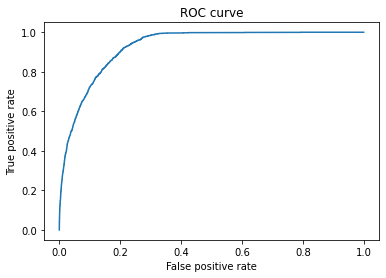

In [20]:
fpr, tpr, threshood = metrics.roc_curve(y_eval, y_scores, pos_label=1)
plt.plot(fpr, tpr, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [22]:
accuracy_score(y_eval,y_hat)

0.9211483865808309

## Feature importance

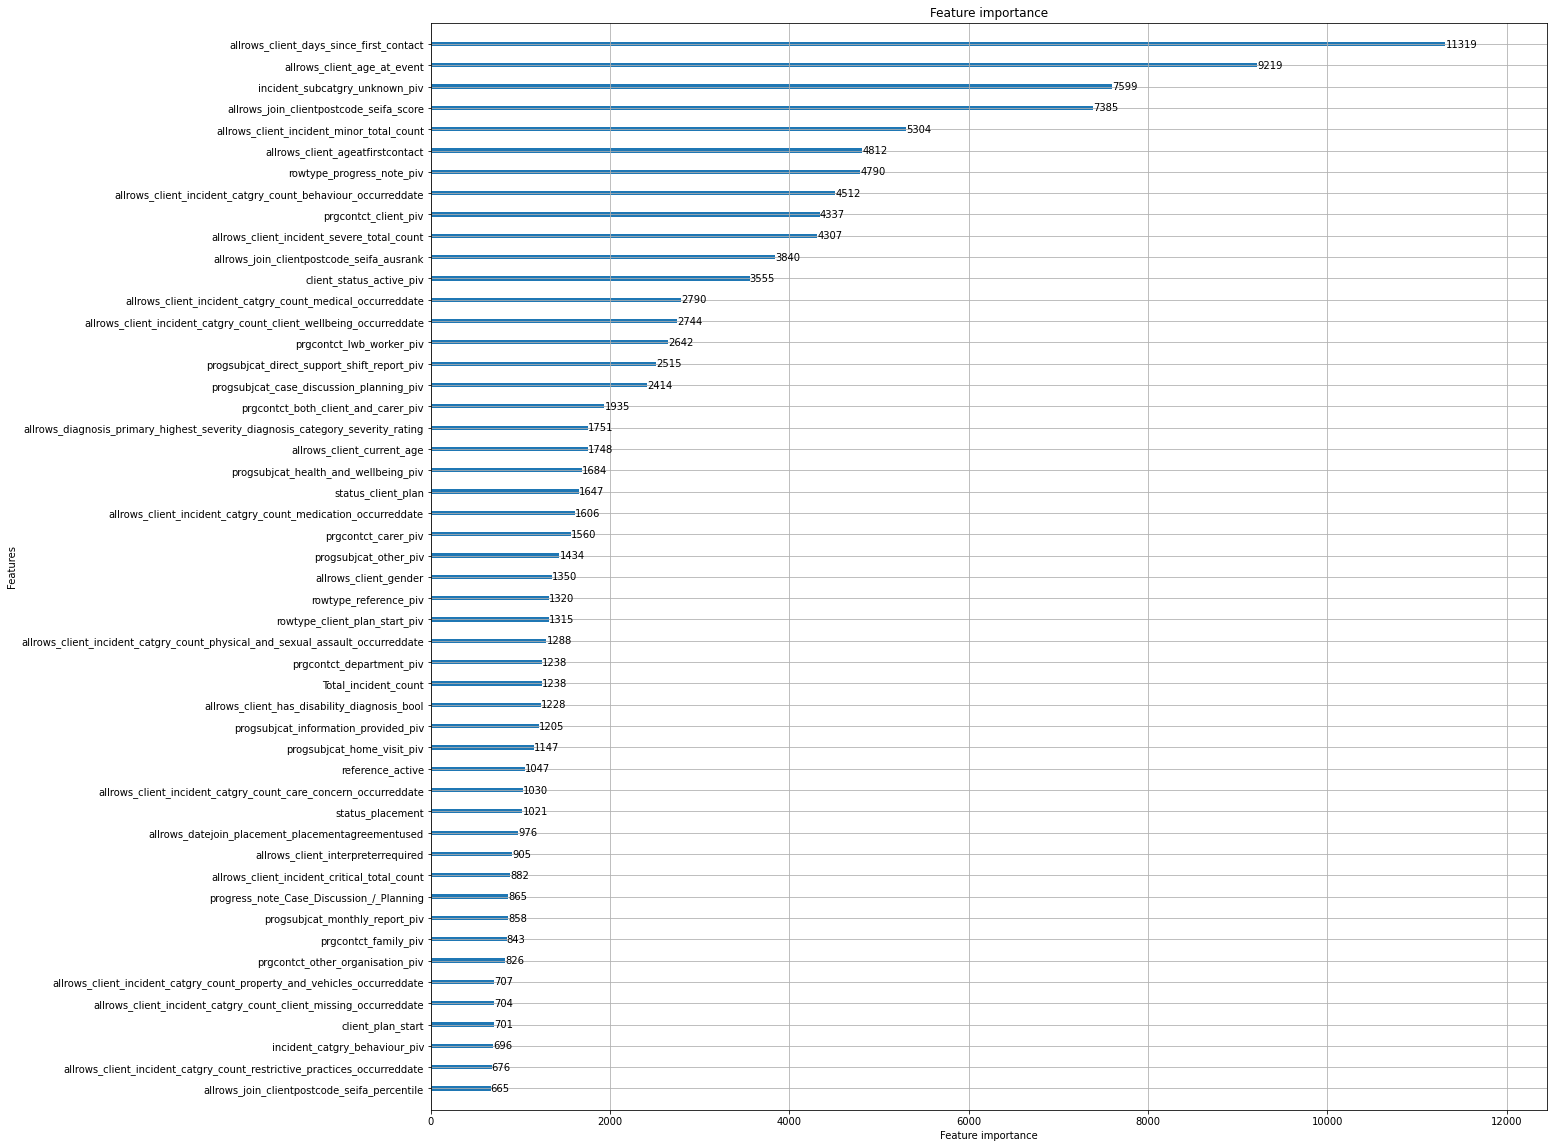

In [23]:
ax = lightgbm.plot_importance(model, figsize=(20,20),max_num_features=50)

<AxesSubplot:>

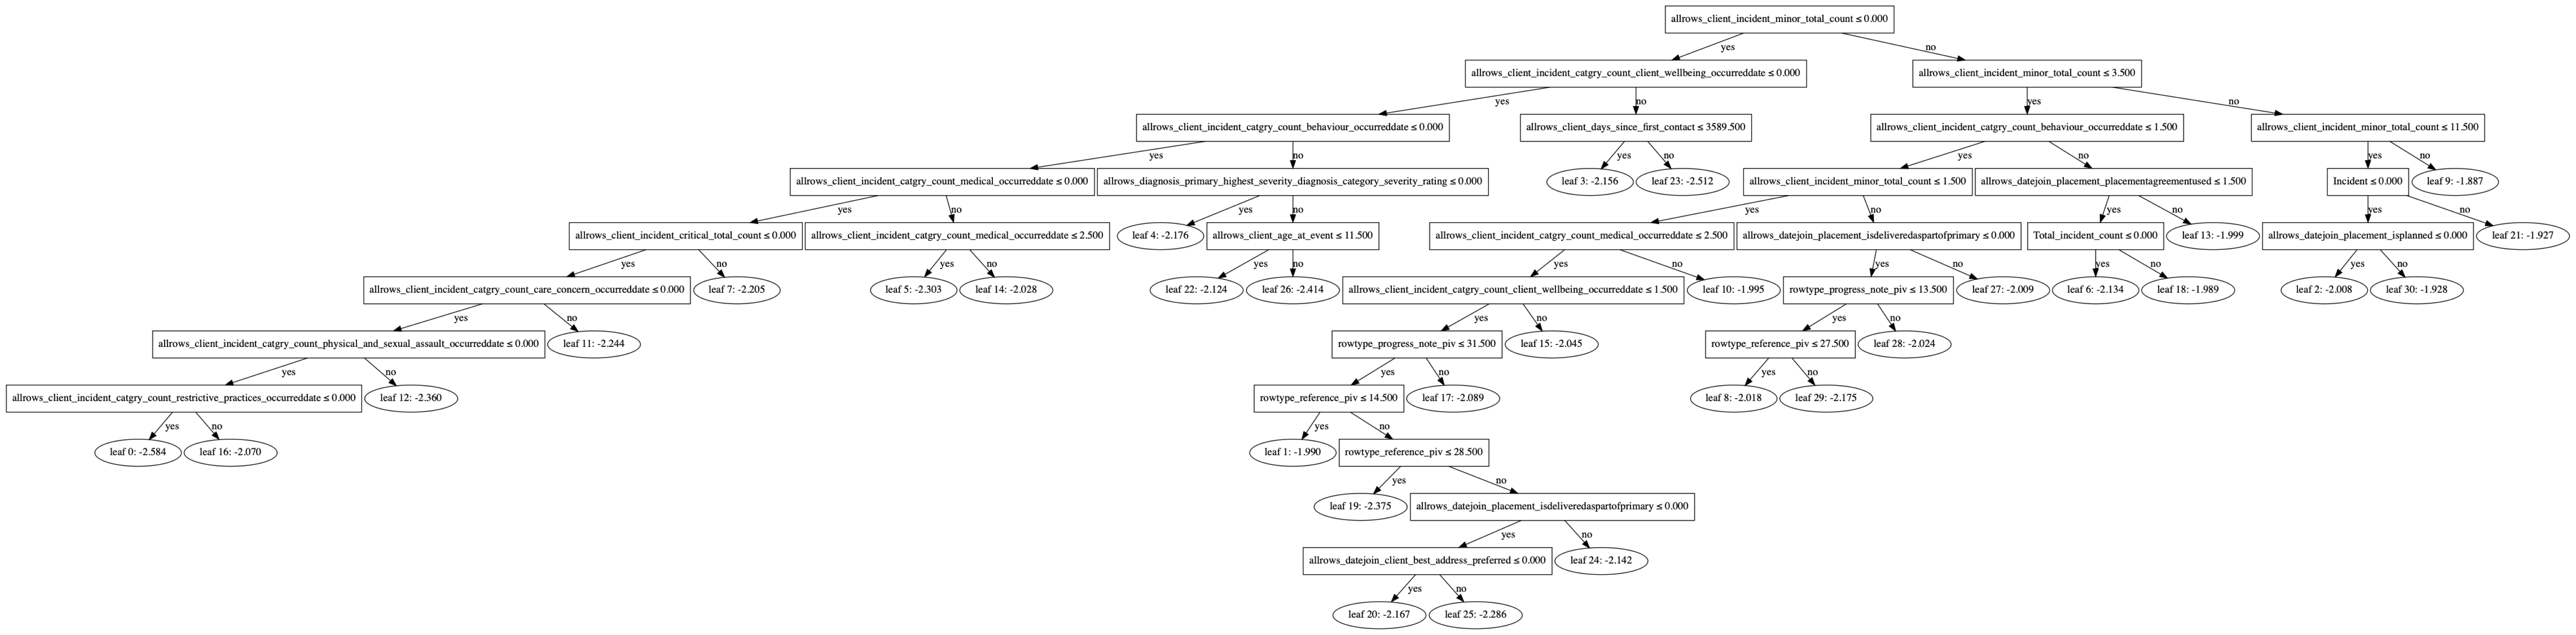

In [24]:
lightgbm.plot_tree(model,figsize=(100,100),orientation='vertical')

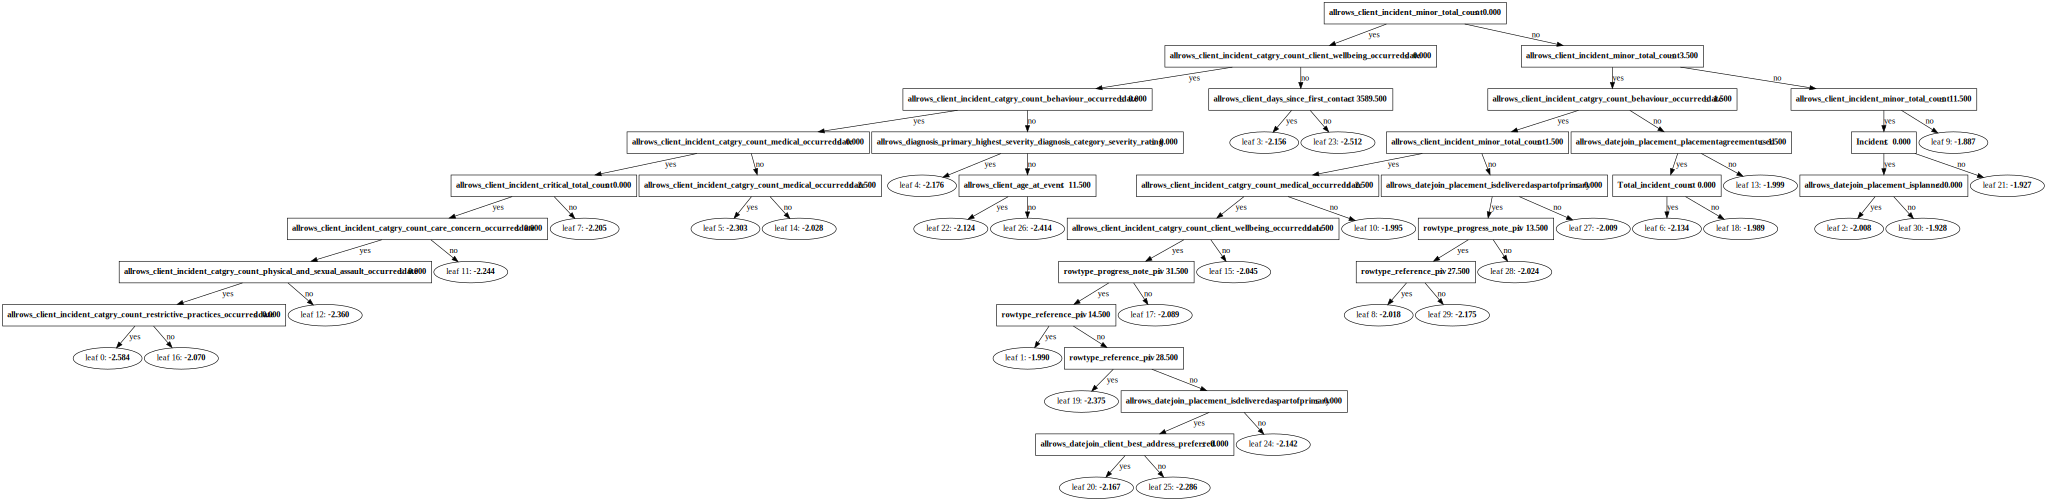

In [25]:
lightgbm.create_tree_digraph(model,orientation='vertical')

# Cross validation

In [26]:
model_cv = lightgbm.cv(parameters,
                       train_data,
                       num_boost_round=2000,return_cvbooster=True)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Curre

In [27]:
cv_result = model_cv["cvbooster"].predict(x_eval)

In [28]:
cv_result = np.array(cv_result)

#### Mean vote

In [29]:
y_hat = np.where(cv_result.mean(axis=0) < 0.5, 0, 1) 
f1_score(y_eval,y_hat)

0.5347732181425486